<a href="https://colab.research.google.com/github/qazwsx351789/QSVM/blob/main/QSVM_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [3]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 59.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

from qutip import expect , Qobj
import qutip
import pandas as pd
import math

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [5]:
import qutip
from qutip import Qobj,basis
from qutip import sigmax , sigmaz , sigmay
import qutip
import math
from qutip.metrics import fidelity
import math
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor

Connect to your goole drive.

# Prepare MNIST data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Show matplotlib graphs in your notebook
%matplotlib inline

In [9]:
from scipy.io import loadmat
mnist = loadmat('/content/drive/MyDrive/QSVM/mnist.mat') # change the file path according to the path where you put mnist.mat on your Google Drive.
traindata = mnist['traindata'][:50000]
trainlabels = mnist['trainlabels'].ravel()[:50000]
validdata = mnist['traindata'][50000:]
validlabels = mnist['trainlabels'].ravel()[50000:]
testdata = mnist['testdata']

print(traindata.shape)
print(trainlabels.shape)
print(validdata.shape)
print(validlabels.shape)
print(testdata.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)


Visulize the images and labels

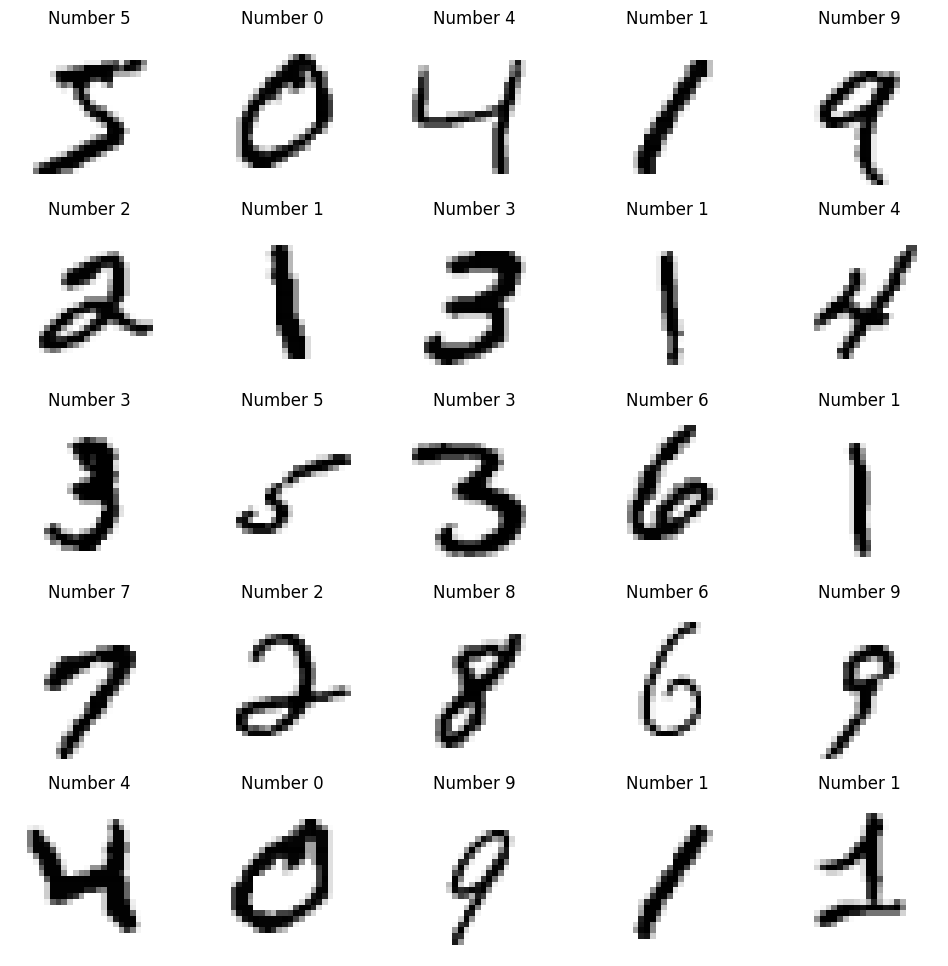

In [10]:

fig, axs = plt.subplots(5, 5, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(traindata[i].reshape((28, 28)), cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('Number {}'.format(trainlabels[i]))

## PCA

In [36]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
#step1
scaler = StandardScaler()
train = scaler.fit_transform(traindata)
valid = scaler.fit_transform(validdata)
test = scaler.fit_transform(testdata)

#step2
cov_train = np.cov(train.T)

#step3
eig_vals, eig_vecs = LA.eig(cov_train)

#step4
sort_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[:, sort_indices]

#step5
k = 12 ## The number of features after PCA
eig_vec = eig_vecs[:, :k]


#step6
train_pca = np.dot(train, eig_vec)
valid_pca = np.dot(valid, eig_vec)
test_pca = np.dot(test, eig_vec)



### approach 2

In [37]:
# pca_on = True
# PCA_n = 12
# if pca_on :
#   color = np.array([1,1,0,1])
#   pca = PCA(n_components=PCA_n)
#   pca.fit(train)
#   train_pca = pca.transform(train)
#   valid_pca = pca.transform(test)
#   print(train_pca.shape , valid_pca.shape)